### Library

In [1]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2
import time
import copy
import timm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import torchvision

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

from efficientnet_pytorch import EfficientNet

from PIL import Image

import warnings
warnings.filterwarnings(action='ignore') 

c:\Users\alstn\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setting

In [2]:
# Hyperparameter
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':3,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE': 256,
    'SEED':41
}

# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# seed
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

cuda:0


In [3]:
size = print(EfficientNet.get_image_size("efficientnet-b2"))
size

260


### Data

#### all

In [4]:
img_dir = os.getcwd()

img_folder = glob.glob(img_dir + '\\train\\*')

all_img_list = []

for folder in img_folder:
    imgs = glob.glob(folder + '\\*')
    all_img_list += imgs

In [5]:
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : str(x).split('\\')[-2])
df

,img_path,label
0,c:\Programing\competition\Dobae\train\a\0.png,a
1,c:\Programing\competition\Dobae\train\a\1.png,a
2,c:\Programing\competition\Dobae\train\a\10.png,a
3,c:\Programing\competition\Dobae\train\a\11.png,a
4,c:\Programing\competition\Dobae\train\a\2.png,a
...,...,...
3452,c:\Programing\competition\Dobae\train\s\995.png,s
3453,c:\Programing\competition\Dobae\train\s\996.png,s
3454,c:\Programing\competition\Dobae\train\s\997.png,s
3455,c:\Programing\competition\Dobae\train\s\998.png,s


#### rotate

In [6]:
# rotate 훼손, 오염, 걸베받이수정, 꼬임, 몰딩수정
df_1 = df.copy()
drop_idx = df_1[(df_1['label'] == 's') | (df_1['label'] == 'k') | (df_1['label'] == 'b') | (df_1['label'] == 'd') | (df_1['label'] == 'h')].index
df_1.drop(drop_idx, inplace = True)
df_1

,img_path,label
0,c:\Programing\competition\Dobae\train\a\0.png,a
1,c:\Programing\competition\Dobae\train\a\1.png,a
2,c:\Programing\competition\Dobae\train\a\10.png,a
3,c:\Programing\competition\Dobae\train\a\11.png,a
4,c:\Programing\competition\Dobae\train\a\2.png,a
...,...,...
2047,c:\Programing\competition\Dobae\train\r\50.png,r
2048,c:\Programing\competition\Dobae\train\r\6.png,r
2049,c:\Programing\competition\Dobae\train\r\7.png,r
2050,c:\Programing\competition\Dobae\train\r\8.png,r


#### small

In [7]:
df_0 = df.copy()
drop_idx = df_0[(df_0['label'] == 's') | (df_0['label'] == 'k')].index
df_0.drop(drop_idx, inplace = True)
df_0

,img_path,label
0,c:\Programing\competition\Dobae\train\a\0.png,a
1,c:\Programing\competition\Dobae\train\a\1.png,a
2,c:\Programing\competition\Dobae\train\a\10.png,a
3,c:\Programing\competition\Dobae\train\a\11.png,a
4,c:\Programing\competition\Dobae\train\a\2.png,a
...,...,...
2047,c:\Programing\competition\Dobae\train\r\50.png,r
2048,c:\Programing\competition\Dobae\train\r\6.png,r
2049,c:\Programing\competition\Dobae\train\r\7.png,r
2050,c:\Programing\competition\Dobae\train\r\8.png,r


In [8]:
# 반점 i 틈새과다 q 가구수정 a 녹오염 e 이음부불량 n 창틀문틀수정 o 울음 m
# | (df_2['label'] == 'm')
df_2 = df.copy()
df_2 = df_2[(df_2['label'] == 'i') | (df_2['label'] == 'q') | (df_2['label'] == 'a') | (df_2['label'] == 'e') | (df_2['label'] == 'n') | (df_2['label'] == 'o') | (df_2['label'] == 'm')]
df_2 = df_2.reset_index(drop=True)
df_2

,img_path,label
0,c:\Programing\competition\Dobae\train\a\0.png,a
1,c:\Programing\competition\Dobae\train\a\1.png,a
2,c:\Programing\competition\Dobae\train\a\10.png,a
3,c:\Programing\competition\Dobae\train\a\11.png,a
4,c:\Programing\competition\Dobae\train\a\2.png,a
...,...,...
95,c:\Programing\competition\Dobae\train\q\0.png,q
96,c:\Programing\competition\Dobae\train\q\1.png,q
97,c:\Programing\competition\Dobae\train\q\2.png,q
98,c:\Programing\competition\Dobae\train\q\3.png,q


In [9]:
train, val, _, _ = train_test_split(df, df['label'],
                                    test_size=0.5,
                                    stratify=df['label'],
                                    random_state = CFG['SEED'])

In [10]:
train['label'].value_counts()

label
s    702
k    297
b    153
d    105
p     81
c     72
l     71
h     65
g     49
j     28
f     27
r     26
o     14
m     11
n      9
e      7
a      6
q      3
i      2
Name: count, dtype: int64

In [11]:
val['label'].value_counts()

label
s    703
k    298
b    154
d    105
p     81
c     73
l     71
h     65
g     50
j     29
f     27
r     25
o     13
m     11
n      8
e      7
a      6
q      2
i      1
Name: count, dtype: int64

In [12]:
df_3 = train.copy()
df_3 = df_3[(df_3['label'] == 'i') | (df_3['label'] == 'q') | (df_3['label'] == 'a') | (df_3['label'] == 'e') | (df_3['label'] == 'n') | (df_3['label'] == 'o') | (df_3['label'] == 'm')]
df_3 = df_3.reset_index(drop=True)

In [13]:
df_4= train.copy()
drop_idx = df_4[(df_4['label'] == 's') | (df_4['label'] == 'k') | (df_4['label'] == 'b') | (df_4['label'] == 'd') | (df_4['label'] == 'p') | (df_4['label'] == 'l') | (df_4['label'] == 'c') | (df_4['label'] == 'g') | (df_4['label'] == 'h') ].index
df_4.drop(drop_idx, inplace = True)
df_4

,img_path,label
1013,c:\Programing\competition\Dobae\train\j\44.png,j
2032,c:\Programing\competition\Dobae\train\r\37.png,r
1794,c:\Programing\competition\Dobae\train\n\12.png,n
1833,c:\Programing\competition\Dobae\train\o\9.png,o
1775,c:\Programing\competition\Dobae\train\m\15.png,m
...,...,...
1793,c:\Programing\competition\Dobae\train\n\11.png,n
739,c:\Programing\competition\Dobae\train\f\7.png,f
2002,c:\Programing\competition\Dobae\train\r\1.png,r
698,c:\Programing\competition\Dobae\train\f\18.png,f


In [14]:
df_5 = train.copy()
drop_idx = df_5[(df_5['label'] == 's') | (df_5['label'] == 'k')].index
df_5.drop(drop_idx, inplace = True)
df_5

,img_path,label
953,c:\Programing\competition\Dobae\train\h\83.png,h
1901,c:\Programing\competition\Dobae\train\p\159.png,p
1013,c:\Programing\competition\Dobae\train\j\44.png,j
1749,c:\Programing\competition\Dobae\train\l\82.png,l
2032,c:\Programing\competition\Dobae\train\r\37.png,r
...,...,...
1906,c:\Programing\competition\Dobae\train\p\18.png,p
2002,c:\Programing\competition\Dobae\train\r\1.png,r
698,c:\Programing\competition\Dobae\train\f\18.png,f
376,c:\Programing\competition\Dobae\train\c\2.png,c


### Label-Encoding

In [15]:
le = preprocessing.LabelEncoder()

df['label'] = le.fit_transform(df['label'])
df_0['label'] = le.fit_transform(df_0['label'])
df_1['label'] = le.fit_transform(df_1['label'])
df_2['label'] = le.fit_transform(df_2['label'])
df_3['label'] = le.fit_transform(df_3['label'])
df_4['label'] = le.fit_transform(df_4['label'])
df_5['label'] = le.fit_transform(df_5['label'])
train['label'] = le.fit_transform(train['label'])
val['label'] = le.transform(val['label'])

print(le.classes_)

['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's']


### Dataset

In [16]:
# cgan , smote, adasyn, b smote, gan

In [17]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        # image = cv2.imread(img_path)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.open(img_path)
        image = np.array(image)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

#### Normalize

In [57]:
mean_transform = A.Compose([
                            A.Resize(224,224),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                            ToTensorV2()
                            ])

In [58]:
mean_dataset = CustomDataset(train['img_path'].values, train['label'].values, mean_transform)

In [ ]:
meanstd_loader = DataLoader(mean_dataset, batch_size = 32, num_workers=0)


print('==> Computing mean and std..')
mean = torch.zeros(3)
std = torch.zeros(3)

for inputs, _labels in meanstd_loader:
    for i in range(3):
        mean[i] += inputs[:,i,:,:].mean()
        std[i] += inputs[:,i,:,:].std()
mean.div_(len(meanstd_loader))
std.div_(len(meanstd_loader))
print(mean, std)

#### augmentation

In [18]:
train_transform = A.Compose([
                            A.Resize(260,260),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),max_pixel_value=255.0),
                            A.HorizontalFlip(p = 1),
                            A.RandomBrightness(p = 1),
                            A.GaussianBlur(p = 1),
                            ToTensorV2()
                            ])

horizon_transform = A.Compose([
                            A.Resize(260,260),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),max_pixel_value=255.0),
                            A.RandomBrightness(p = 1),
                            A.HorizontalFlip(p = 1),
                            ToTensorV2()
                            ])

vertical_transform = A.Compose([
                            A.Resize(260,260),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),max_pixel_value=255.0),
                            A.RandomBrightness(p = 1),
                            A.VerticalFlip(p = 1),
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                            A.Resize(260,260),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),max_pixel_value=255.0),
                            # A.RandomBrightness(p = 0.5),
                            # A.HorizontalFlip(p = 0.5),
                            # A.GaussianBlur(),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(260,260),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),max_pixel_value=255.0),
                            # A.RandomBrightness(p = 0.5),
                            # A.HorizontalFlip(p = 0.5),
                            # A.GaussianBlur(),
                            ToTensorV2()
                            ])

original_transform = A.Compose([
                            A.Resize(260,260),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),max_pixel_value=255.0),
                            ToTensorV2()
                            ])

ro_transform = A.Compose([
                            A.Resize(260,260),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225),max_pixel_value=255.0),
                            # A.HorizontalFlip(p = 0.5),
                            # A.RandomBrightness(),
                            # A.GaussianBlur(),
                            # A.RandomRotate90(),
                            A.Rotate(),
                            ToTensorV2()
                            ])

small_transform = A.Compose([
                            A.Resize(260,260),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                            A.RandomBrightness(p = 1),
                            A.GaussianBlur(p = 1),
                            ToTensorV2()
                            ])

small_transform = A.Compose([
                            A.Resize(260,260),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                            ToTensorV2()
                            ])

small_2_transform = A.Compose([
                            A.Resize(260,260),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                            A.HorizontalFlip(p = 1),
                            A.GaussianBlur(p = 1),
                            ToTensorV2()
                            ])

In [23]:
## 전체를 늘리고 나누기
original_dataset = CustomDataset(df['img_path'], df['label'], original_transform)
aug_dataset = CustomDataset(df['img_path'], df['label'], vertical_transform)
aug_1_dataset = CustomDataset(df['img_path'], df['label'], horizon_transform)
dataset = torch.utils.data.ConcatDataset((aug_dataset, aug_1_dataset, original_dataset))

print(len(dataset) - len(dataset)*0.3)


7259.700000000001


In [24]:
len(dataset)-7260

3111

In [25]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [7260, 3111])

train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers = 0)
val_dataloader = DataLoader(val_dataset, batch_size = 32, shuffle = False, num_workers = 0)

In [53]:
## 자르고 넣기(val이랑 안겹치게...)
train_dataset = CustomDataset(train['img_path'].values, train['label'].values,train_transform)
val_dataset = CustomDataset(val['img_path'].values, val['label'].values, test_transform)

original = CustomDataset(df['img_path'].values, df['label'].values, original_transform)
# original = CustomDataset(df_0['img_path'].values, df_0['label'].values, original_transform)
# original = CustomDataset(df_5['img_path'].values, df_5['label'].values, original_transform)

# rotate = CustomDataset(df_1['img_path'].values, df_1['label'].values, ro_transform)
# rotate_2 = CustomDataset(train['img_path'].values, train['label'].values, ro_transform)

small = CustomDataset(df_2['img_path'].values, df_2['label'].values, small_transform)

# small = CustomDataset(df_3['img_path'].values, df_3['label'].values, small_transform)
# small_2 = CustomDataset(df_4['img_path'].values, df_4['label'].values, small_transform)
# for i in range(2) :
#     small += CustomDataset(df_3['img_path'].values, df_3['label'].values, small_transform)
small = small + small

In [54]:
train_dataset = torch.utils.data.ConcatDataset((train_dataset, original, small))
print(train_dataset.__len__())
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = False, num_workers = 0)
val_dataloader = DataLoader(val_dataset, batch_size = 32, shuffle = False, num_workers = 0)

5385


### Model

##### CoAtNet

In [77]:
import torch
import torch.nn as nn

from einops import rearrange
from einops.layers.torch import Rearrange

def conv_3x3_bn(inp, oup, image_size, downsample=False):
    stride = 1 if downsample == False else 2
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.GELU()
    )

class PreNorm(nn.Module):
    def __init__(self, dim, fn, norm):
        super().__init__()
        self.norm = norm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class SE(nn.Module):
    def __init__(self, inp, oup, expansion=0.25):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(oup, int(inp * expansion), bias=False),
            nn.GELU(),
            nn.Linear(int(inp * expansion), oup, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class MBConv(nn.Module):
    def __init__(self, inp, oup, image_size, downsample=False, expansion=4):
        super().__init__()
        self.downsample = downsample
        stride = 1 if self.downsample == False else 2
        hidden_dim = int(inp * expansion)

        if self.downsample:
            self.pool = nn.MaxPool2d(3, 2, 1)
            self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride,
                          1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                # down-sample in the first conv
                nn.Conv2d(inp, hidden_dim, 1, stride, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, 1, 1,
                          groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                SE(inp, hidden_dim),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        
        self.conv = PreNorm(inp, self.conv, nn.BatchNorm2d)

    def forward(self, x):
        if self.downsample:
            return self.proj(self.pool(x)) + self.conv(x)
        else:
            return x + self.conv(x)

class Attention(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == inp)

        self.ih, self.iw = image_size

        self.heads = heads
        self.scale = dim_head ** -0.5

        # parameter table of relative position bias
        self.relative_bias_table = nn.Parameter(
            torch.zeros((2 * self.ih - 1) * (2 * self.iw - 1), heads))

        coords = torch.meshgrid((torch.arange(self.ih), torch.arange(self.iw)))
        coords = torch.flatten(torch.stack(coords), 1)
        relative_coords = coords[:, :, None] - coords[:, None, :]

        relative_coords[0] += self.ih - 1
        relative_coords[1] += self.iw - 1
        relative_coords[0] *= 2 * self.iw - 1
        relative_coords = rearrange(relative_coords, 'c h w -> h w c')
        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index", relative_index)

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(inp, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, oup),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(
            t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        # Use "gather" for more efficiency on GPUs
        relative_bias = self.relative_bias_table.gather(
            0, self.relative_index.repeat(1, self.heads))
        relative_bias = rearrange(
            relative_bias, '(h w) c -> 1 c h w', h=self.ih*self.iw, w=self.ih*self.iw)
        dots = dots + relative_bias

        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, downsample=False, dropout=0.):
        super().__init__()
        hidden_dim = int(inp * 4)

        self.ih, self.iw = image_size
        self.downsample = downsample

        if self.downsample:
            self.pool1 = nn.MaxPool2d(3, 2, 1)
            self.pool2 = nn.MaxPool2d(3, 2, 1)
            self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)

        self.attn = Attention(inp, oup, image_size, heads, dim_head, dropout)
        self.ff = FeedForward(oup, hidden_dim, dropout)

        self.attn = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(inp, self.attn, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

        self.ff = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(oup, self.ff, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

    def forward(self, x):
        if self.downsample:
            x = self.proj(self.pool1(x)) + self.attn(self.pool2(x))
        else:
            x = x + self.attn(x)
        x = x + self.ff(x)
        return x

class CoAtNet(nn.Module):
    def __init__(self, image_size, in_channels, num_blocks, channels, num_classes=1000, block_types=['C', 'C', 'T', 'T']):
        super().__init__()
        ih, iw = image_size
        block = {'C': MBConv, 'T': Transformer}

        self.s0 = self._make_layer(
            conv_3x3_bn, in_channels, channels[0], num_blocks[0], (ih // 2, iw // 2))
        self.s1 = self._make_layer(
            block[block_types[0]], channels[0], channels[1], num_blocks[1], (ih // 4, iw // 4))
        self.s2 = self._make_layer(
            block[block_types[1]], channels[1], channels[2], num_blocks[2], (ih // 8, iw // 8))
        self.s3 = self._make_layer(
            block[block_types[2]], channels[2], channels[3], num_blocks[3], (ih // 16, iw // 16))
        self.s4 = self._make_layer(
            block[block_types[3]], channels[3], channels[4], num_blocks[4], (ih // 32, iw // 32))

        self.pool = nn.AvgPool2d(ih // 32, 1)
        self.fc = nn.Linear(channels[-1], num_classes, bias=False)

    def forward(self, x):
        x = self.s0(x)
        x = self.s1(x)
        x = self.s2(x)
        x = self.s3(x)
        x = self.s4(x)

        x = self.pool(x).view(-1, x.shape[1])
        x = self.fc(x)
        return x

    def _make_layer(self, block, inp, oup, depth, image_size):
        layers = nn.ModuleList([])
        for i in range(depth):
            if i == 0:
                layers.append(block(inp, oup, image_size, downsample=True))
            else:
                layers.append(block(oup, oup, image_size))
        return nn.Sequential(*layers)

def coatnet_0():
    num_blocks = [2, 2, 3, 5, 2]            # L
    channels = [64, 96, 192, 384, 768]      # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)

def coatnet_1():
    num_blocks = [2, 2, 6, 14, 2]           # L
    channels = [64, 96, 192, 384, 768]      # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)

def coatnet_2():
    num_blocks = [2, 2, 6, 14, 2]           # L
    channels = [128, 128, 256, 512, 1026]   # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)

def coatnet_3():
    num_blocks = [2, 2, 6, 14, 2]           # L
    channels = [192, 192, 384, 768, 1536]   # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)

def coatnet_4():
    num_blocks = [2, 2, 12, 28, 2]          # L
    channels = [192, 192, 384, 768, 1536]   # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# if __name__ == '__main__':
#     img = torch.randn(1, 3, 224, 224)

#     net = coatnet_0()
#     out = net(img)
#     print(out.shape, count_parameters(net))

#     net = coatnet_1()
#     out = net(img)
#     print(out.shape, count_parameters(net))

#     net = coatnet_2()
#     out = net(img)
#     print(out.shape, count_parameters(net))

#     net = coatnet_3()
#     out = net(img)
#     print(out.shape, count_parameters(net))

#     net = coatnet_4()
#     out = net(img)
#     print(out.shape, count_parameters(net))

#### model

In [26]:
## efficientnet
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.backbone = models.efficientnet_b2(pretrained=True)
        # self.backbone = timm.create_model('tf_efficientnetv2_s', pretrained=True)
        self.classifier = nn.Linear(1000, 19)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x
    
model = BaseModel()

In [14]:
# resnet
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        # self.backbone = timm.create_model('tf_efficientnetv2_s', pretrained=True)
        self.classifier = nn.Linear(1000, 19)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x
    
model = ResNetModel()
model

# class RESNET18(nn.Module):
#     def __init__(self, out_channels):
#         super(RESNET18, self).__init__()
#         self.res18 = models.resnet18(pretrained=False)
#         self.res18.fc = nn.Linear(in_features=self.res18.fc.in_features, out_features=out_channels)
#         self.feature1 = nn.Sequential(*(list(self.res18.children())[0:8]))
#         self.feature2 = nn.Sequential(list(self.res18.children())[8])
#         self.feature3 = nn.Sequential(list(self.res18.children())[9])

#     def forward(self, x):
#         map = self.feature1(x)
#         h1 = self.feature2(map)
#         output = self.feature3(h1.reshape(h1.shape[0], -1))
#         return output

# model = RESNET18(19)

ResNetModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

#### mult model

In [27]:
class MultiLabelEfficientnet(nn.Module):
    def __init__(self):
        super(MultiLabelEfficientnet, self).__init__()
        self.efficientnet = models.efficientnet_b2(pretrained=True)
        self.drop = nn.Dropout(p=0.2)
        self.FC = nn.Linear(1000, 19)

    def forward(self, x):
        x = F.silu(self.efficientnet(x))
        x = self.drop(x)
        x = torch.sigmoid(self.FC(x))
        return x

model = MultiLabelEfficientnet()
model

MultiLabelEfficientnet(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
      

In [ ]:
from efficientnet_pytorch import EfficientNet
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# A memory-efficient implementation of Swish function
class SwishImplementation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))

class MemoryEfficientSwish(nn.Module):
    def forward(self, x):
        return SwishImplementation.apply(x)
        
class MultiLabelEfficientnet2(nn.Module):
    def __init__(self):
        super(MultiLabelEfficientnet2, self).__init__()
        # self.conv2d = nn.Conv2d(1, 3, 3, stride=1)
        self._swish = MemoryEfficientSwish()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b7')
        self.fc = nn.Linear(1000, 19)


        x = self._swish(self.conv2d(x))
        x = self._swish(self.efficientnet(x))
        x = torch.sigmoid(self.fc(x))
        return x

model2 = MultiLabelEfficientnet2()
model2

### Train

In [28]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.type(torch.LongTensor).to(device) 
            
            pred = model(imgs)
            
            loss = criterion(pred, labels)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()
            
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')
    
    return _val_loss, _val_score, true_labels, preds

In [29]:
def train_start(model, optimizer, train_loader, val_loader, scheduler, num_epochs):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    best_score = 0
    best_model = None
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.type(torch.LongTensor).to(device) 
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score, true_labels, preds = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')
       
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_score < _val_score:
            best_idx = epoch
            best_score = _val_score
            best_model = model
    
    return best_model, true_labels, preds

In [30]:
from lion_pytorch import Lion

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu
print(device)

model = model.to(device)
# model.cuda()

criterion = nn.CrossEntropyLoss() # torch.nn.BCELoss()
criterion.to(device)

# ## best
# optimizer = Lion(model.parameters(), 
#                          lr = 3e-4,
#                          weight_decay = 0.002,
#                          betas = (0.9, 0.999))
# lmbda = lambda epoch: 0.95
# scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda = lmbda)

## soso
optimizer = torch.optim.AdamW(params = model.parameters(), lr = 3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

cuda:0


In [31]:
import GPUtil
import torch

print(torch.cuda.empty_cache())
print(torch.cuda.memory_reserved())
print(torch.cuda.memory_allocated())
print(GPUtil.showUtilization())

None
44040192
36922880
| ID | GPU | MEM |
------------------
|  0 |  4% |  5% |
None


In [44]:
infer_model , true_labels, preds = train_start(model,
                                               optimizer,
                                               train_dataloader,
                                               val_dataloader,
                                               scheduler,
                                               num_epochs = 50)

Epoch 0/49
----------


100%|██████████| 98/98 [00:28<00:00,  3.38it/s]


Epoch [0], Train Loss : [2.10607] Val Loss : [2.12759] Val Weighted F1 Score : [0.82947]
Epoch 1/49
----------


100%|██████████| 98/98 [00:28<00:00,  3.39it/s]


Epoch [1], Train Loss : [2.09914] Val Loss : [2.11447] Val Weighted F1 Score : [0.84776]
Epoch 2/49
----------


100%|██████████| 98/98 [00:28<00:00,  3.40it/s]


Epoch [2], Train Loss : [2.09565] Val Loss : [2.11973] Val Weighted F1 Score : [0.84772]
Epoch 3/49
----------


100%|██████████| 98/98 [00:29<00:00,  3.38it/s]


Epoch [3], Train Loss : [2.10150] Val Loss : [2.12037] Val Weighted F1 Score : [0.82865]
Epoch 4/49
----------


100%|██████████| 98/98 [00:28<00:00,  3.38it/s]


Epoch [4], Train Loss : [2.10006] Val Loss : [2.12979] Val Weighted F1 Score : [0.82237]
Epoch 00016: reducing learning rate of group 0 to 1.5000e-04.
Epoch 5/49
----------


100%|██████████| 98/98 [00:28<00:00,  3.39it/s]


Epoch [5], Train Loss : [2.08568] Val Loss : [2.11223] Val Weighted F1 Score : [0.87015]
Epoch 6/49
----------


100%|██████████| 98/98 [00:29<00:00,  3.38it/s]


Epoch [6], Train Loss : [2.07616] Val Loss : [2.10628] Val Weighted F1 Score : [0.85631]
Epoch 7/49
----------


100%|██████████| 98/98 [00:29<00:00,  3.38it/s]


Epoch [7], Train Loss : [2.07427] Val Loss : [2.10470] Val Weighted F1 Score : [0.87933]
Epoch 8/49
----------


100%|██████████| 98/98 [00:28<00:00,  3.38it/s]


Epoch [8], Train Loss : [2.07262] Val Loss : [2.10131] Val Weighted F1 Score : [0.88233]
Epoch 9/49
----------


100%|██████████| 98/98 [00:28<00:00,  3.38it/s]


Epoch [9], Train Loss : [2.06812] Val Loss : [2.09838] Val Weighted F1 Score : [0.88753]
Epoch 10/49
----------


100%|██████████| 98/98 [00:29<00:00,  3.38it/s]


Epoch [10], Train Loss : [2.06605] Val Loss : [2.09964] Val Weighted F1 Score : [0.88592]
Epoch 11/49
----------


100%|██████████| 98/98 [00:29<00:00,  3.38it/s]


Epoch [11], Train Loss : [2.06827] Val Loss : [2.09819] Val Weighted F1 Score : [0.89143]
Epoch 12/49
----------


100%|██████████| 98/98 [00:29<00:00,  3.37it/s]


Epoch [12], Train Loss : [2.06850] Val Loss : [2.10509] Val Weighted F1 Score : [0.88596]
Epoch 13/49
----------


100%|██████████| 98/98 [00:29<00:00,  3.37it/s]


Epoch [13], Train Loss : [2.06449] Val Loss : [2.09604] Val Weighted F1 Score : [0.88813]
Epoch 14/49
----------


100%|██████████| 98/98 [00:29<00:00,  3.38it/s]


Epoch [14], Train Loss : [2.06484] Val Loss : [2.09993] Val Weighted F1 Score : [0.87124]
Epoch 00026: reducing learning rate of group 0 to 7.5000e-05.
Epoch 15/49
----------


100%|██████████| 98/98 [00:29<00:00,  3.37it/s]


Epoch [15], Train Loss : [2.06207] Val Loss : [2.09234] Val Weighted F1 Score : [0.90875]
Epoch 16/49
----------


100%|██████████| 98/98 [00:29<00:00,  3.37it/s]


Epoch [16], Train Loss : [2.05925] Val Loss : [2.08678] Val Weighted F1 Score : [0.91227]
Epoch 17/49
----------


100%|██████████| 98/98 [00:28<00:00,  3.48it/s]


Epoch [17], Train Loss : [2.05802] Val Loss : [2.08743] Val Weighted F1 Score : [0.90743]
Epoch 18/49
----------


100%|██████████| 98/98 [00:27<00:00,  3.59it/s]


Epoch [18], Train Loss : [2.05721] Val Loss : [2.09329] Val Weighted F1 Score : [0.89898]
Epoch 19/49
----------


100%|██████████| 98/98 [00:28<00:00,  3.48it/s]


Epoch [19], Train Loss : [2.05666] Val Loss : [2.08491] Val Weighted F1 Score : [0.91403]
Epoch 20/49
----------


100%|██████████| 98/98 [00:28<00:00,  3.48it/s]


Epoch [20], Train Loss : [2.05721] Val Loss : [2.08857] Val Weighted F1 Score : [0.90827]
Epoch 21/49
----------


100%|██████████| 98/98 [00:26<00:00,  3.69it/s]


Epoch [21], Train Loss : [2.05644] Val Loss : [2.09076] Val Weighted F1 Score : [0.89901]
Epoch 22/49
----------


100%|██████████| 98/98 [00:27<00:00,  3.57it/s]


Epoch [22], Train Loss : [2.05576] Val Loss : [2.08671] Val Weighted F1 Score : [0.91399]
Epoch 00034: reducing learning rate of group 0 to 3.7500e-05.
Epoch 23/49
----------


100%|██████████| 98/98 [00:28<00:00,  3.41it/s]


Epoch [23], Train Loss : [2.05368] Val Loss : [2.08580] Val Weighted F1 Score : [0.91819]
Epoch 24/49
----------


100%|██████████| 98/98 [00:28<00:00,  3.49it/s]


Epoch [24], Train Loss : [2.05321] Val Loss : [2.08282] Val Weighted F1 Score : [0.92110]
Epoch 25/49
----------


100%|██████████| 98/98 [00:27<00:00,  3.52it/s]


Epoch [25], Train Loss : [2.05317] Val Loss : [2.08353] Val Weighted F1 Score : [0.91949]
Epoch 26/49
----------


100%|██████████| 98/98 [00:27<00:00,  3.58it/s]


Epoch [26], Train Loss : [2.05286] Val Loss : [2.08460] Val Weighted F1 Score : [0.92106]
Epoch 27/49
----------


100%|██████████| 98/98 [00:29<00:00,  3.38it/s]


Epoch [27], Train Loss : [2.05218] Val Loss : [2.08521] Val Weighted F1 Score : [0.91959]
Epoch 00039: reducing learning rate of group 0 to 1.8750e-05.
Epoch 28/49
----------


100%|██████████| 98/98 [00:27<00:00,  3.56it/s]


Epoch [28], Train Loss : [2.05226] Val Loss : [2.08568] Val Weighted F1 Score : [0.92193]
Epoch 29/49
----------


100%|██████████| 98/98 [00:27<00:00,  3.54it/s]


Epoch [29], Train Loss : [2.05112] Val Loss : [2.08188] Val Weighted F1 Score : [0.92397]
Epoch 30/49
----------


100%|██████████| 98/98 [00:27<00:00,  3.58it/s]


Epoch [30], Train Loss : [2.05090] Val Loss : [2.08534] Val Weighted F1 Score : [0.92544]
Epoch 31/49
----------


100%|██████████| 98/98 [00:27<00:00,  3.58it/s]


Epoch [31], Train Loss : [2.05064] Val Loss : [2.08148] Val Weighted F1 Score : [0.92796]
Epoch 32/49
----------


100%|██████████| 98/98 [00:28<00:00,  3.49it/s]


Epoch [32], Train Loss : [2.05076] Val Loss : [2.08376] Val Weighted F1 Score : [0.92303]
Epoch 33/49
----------


100%|██████████| 98/98 [00:27<00:00,  3.55it/s]


Epoch [33], Train Loss : [2.05057] Val Loss : [2.08445] Val Weighted F1 Score : [0.92496]
Epoch 34/49
----------


100%|██████████| 98/98 [00:28<00:00,  3.49it/s]


Epoch [34], Train Loss : [2.05016] Val Loss : [2.08317] Val Weighted F1 Score : [0.92437]
Epoch 00046: reducing learning rate of group 0 to 9.3750e-06.
Epoch 35/49
----------


100%|██████████| 98/98 [00:27<00:00,  3.58it/s]


Epoch [35], Train Loss : [2.05052] Val Loss : [2.08222] Val Weighted F1 Score : [0.92720]
Epoch 36/49
----------


100%|██████████| 98/98 [00:28<00:00,  3.41it/s]


Epoch [36], Train Loss : [2.04989] Val Loss : [2.08204] Val Weighted F1 Score : [0.92431]
Epoch 37/49
----------


100%|██████████| 98/98 [00:28<00:00,  3.50it/s]


Epoch [37], Train Loss : [2.05066] Val Loss : [2.08268] Val Weighted F1 Score : [0.92521]
Epoch 00049: reducing learning rate of group 0 to 4.6875e-06.
Epoch 38/49
----------


100%|██████████| 98/98 [00:27<00:00,  3.58it/s]


Epoch [38], Train Loss : [2.04994] Val Loss : [2.08026] Val Weighted F1 Score : [0.92653]
Epoch 39/49
----------


100%|██████████| 98/98 [00:28<00:00,  3.48it/s]


Epoch [39], Train Loss : [2.05016] Val Loss : [2.08439] Val Weighted F1 Score : [0.92375]
Epoch 40/49
----------


100%|██████████| 98/98 [00:29<00:00,  3.38it/s]


Epoch [40], Train Loss : [2.04950] Val Loss : [2.07890] Val Weighted F1 Score : [0.92446]
Epoch 00052: reducing learning rate of group 0 to 2.3437e-06.
Epoch 41/49
----------


100%|██████████| 98/98 [00:28<00:00,  3.48it/s]


Epoch [41], Train Loss : [2.04945] Val Loss : [2.07898] Val Weighted F1 Score : [0.92482]
Epoch 42/49
----------


100%|██████████| 98/98 [00:29<00:00,  3.36it/s]


Epoch [42], Train Loss : [2.04947] Val Loss : [2.07996] Val Weighted F1 Score : [0.93122]
Epoch 43/49
----------


100%|██████████| 98/98 [00:27<00:00,  3.51it/s]


Epoch [43], Train Loss : [2.05033] Val Loss : [2.08049] Val Weighted F1 Score : [0.92844]
Epoch 44/49
----------


100%|██████████| 98/98 [00:28<00:00,  3.42it/s]


Epoch [44], Train Loss : [2.05002] Val Loss : [2.07884] Val Weighted F1 Score : [0.92794]
Epoch 45/49
----------


100%|██████████| 98/98 [00:29<00:00,  3.36it/s]


Epoch [45], Train Loss : [2.04968] Val Loss : [2.08169] Val Weighted F1 Score : [0.92707]
Epoch 00057: reducing learning rate of group 0 to 1.1719e-06.
Epoch 46/49
----------


100%|██████████| 98/98 [00:28<00:00,  3.48it/s]


Epoch [46], Train Loss : [2.05014] Val Loss : [2.08233] Val Weighted F1 Score : [0.92554]
Epoch 47/49
----------


100%|██████████| 98/98 [00:28<00:00,  3.46it/s]


Epoch [47], Train Loss : [2.04940] Val Loss : [2.08081] Val Weighted F1 Score : [0.92518]
Epoch 48/49
----------


100%|██████████| 98/98 [00:29<00:00,  3.36it/s]


Epoch [48], Train Loss : [2.05026] Val Loss : [2.07920] Val Weighted F1 Score : [0.92671]
Epoch 00060: reducing learning rate of group 0 to 5.8594e-07.
Epoch 49/49
----------


100%|██████████| 98/98 [00:27<00:00,  3.54it/s]

Epoch [49], Train Loss : [2.04941] Val Loss : [2.08004] Val Weighted F1 Score : [0.92733]


In [45]:
class_names = {
    "0": "가구수정",          # a     
    "1": "걸레받이수정",      # b
    "2": "곰팡이",           # c  ....
    "3": "꼬임",             # d
    "4": "녹오염",           # e
    "5": "들뜸",             # f
    "6": "면불량",           # g ....
    "7": "몰딩수정",         # h .....
    "8": "반점",             # i
    "9": "석고수정",         # j
    "10": "오염",            # k
    "11": "오타공",          # l  .....
    "12": "울음",            # m
    "13": "이음부불량",       # n
    "14": "창틀,문틀수정",    # o
    "15": "터짐",            # p  .....   
    "16": "틈새과다",        # q
    "17": "피스",            # r
    "18": "훼손"             # s
}

In [46]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(true_labels, preds)


In [51]:
names = ['가구수정','걸레받이수정','곰팡이','꼬임','녹오염','들뜸','면불량','몰딩수정','반점','석고수정','오염','오타공','울음','이음부불량','창틀,문틀수정','터짐','틈새과다','피스','훼손']

In [52]:
con = pd.DataFrame(conf_matrix, index = names, columns = names )
con

,가구수정,걸레받이수정,곰팡이,꼬임,녹오염,들뜸,면불량,몰딩수정,반점,석고수정,오염,오타공,울음,이음부불량,"창틀,문틀수정",터짐,틈새과다,피스,훼손
가구수정,0,0,0,1,0,4,0,0,0,0,0,0,0,0,0,0,0,0,2
걸레받이수정,0,258,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2
곰팡이,0,5,111,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
꼬임,0,0,0,180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
녹오염,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0
들뜸,0,0,0,0,0,46,0,0,0,0,1,0,0,3,0,0,0,0,0
면불량,0,1,1,0,0,0,76,0,0,0,1,0,1,0,0,3,0,1,10
몰딩수정,0,0,0,0,0,0,1,128,0,0,0,0,0,0,0,0,0,1,2
반점,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
석고수정,0,0,0,0,0,0,0,0,0,40,0,1,0,0,0,0,0,1,4


<Axes: >

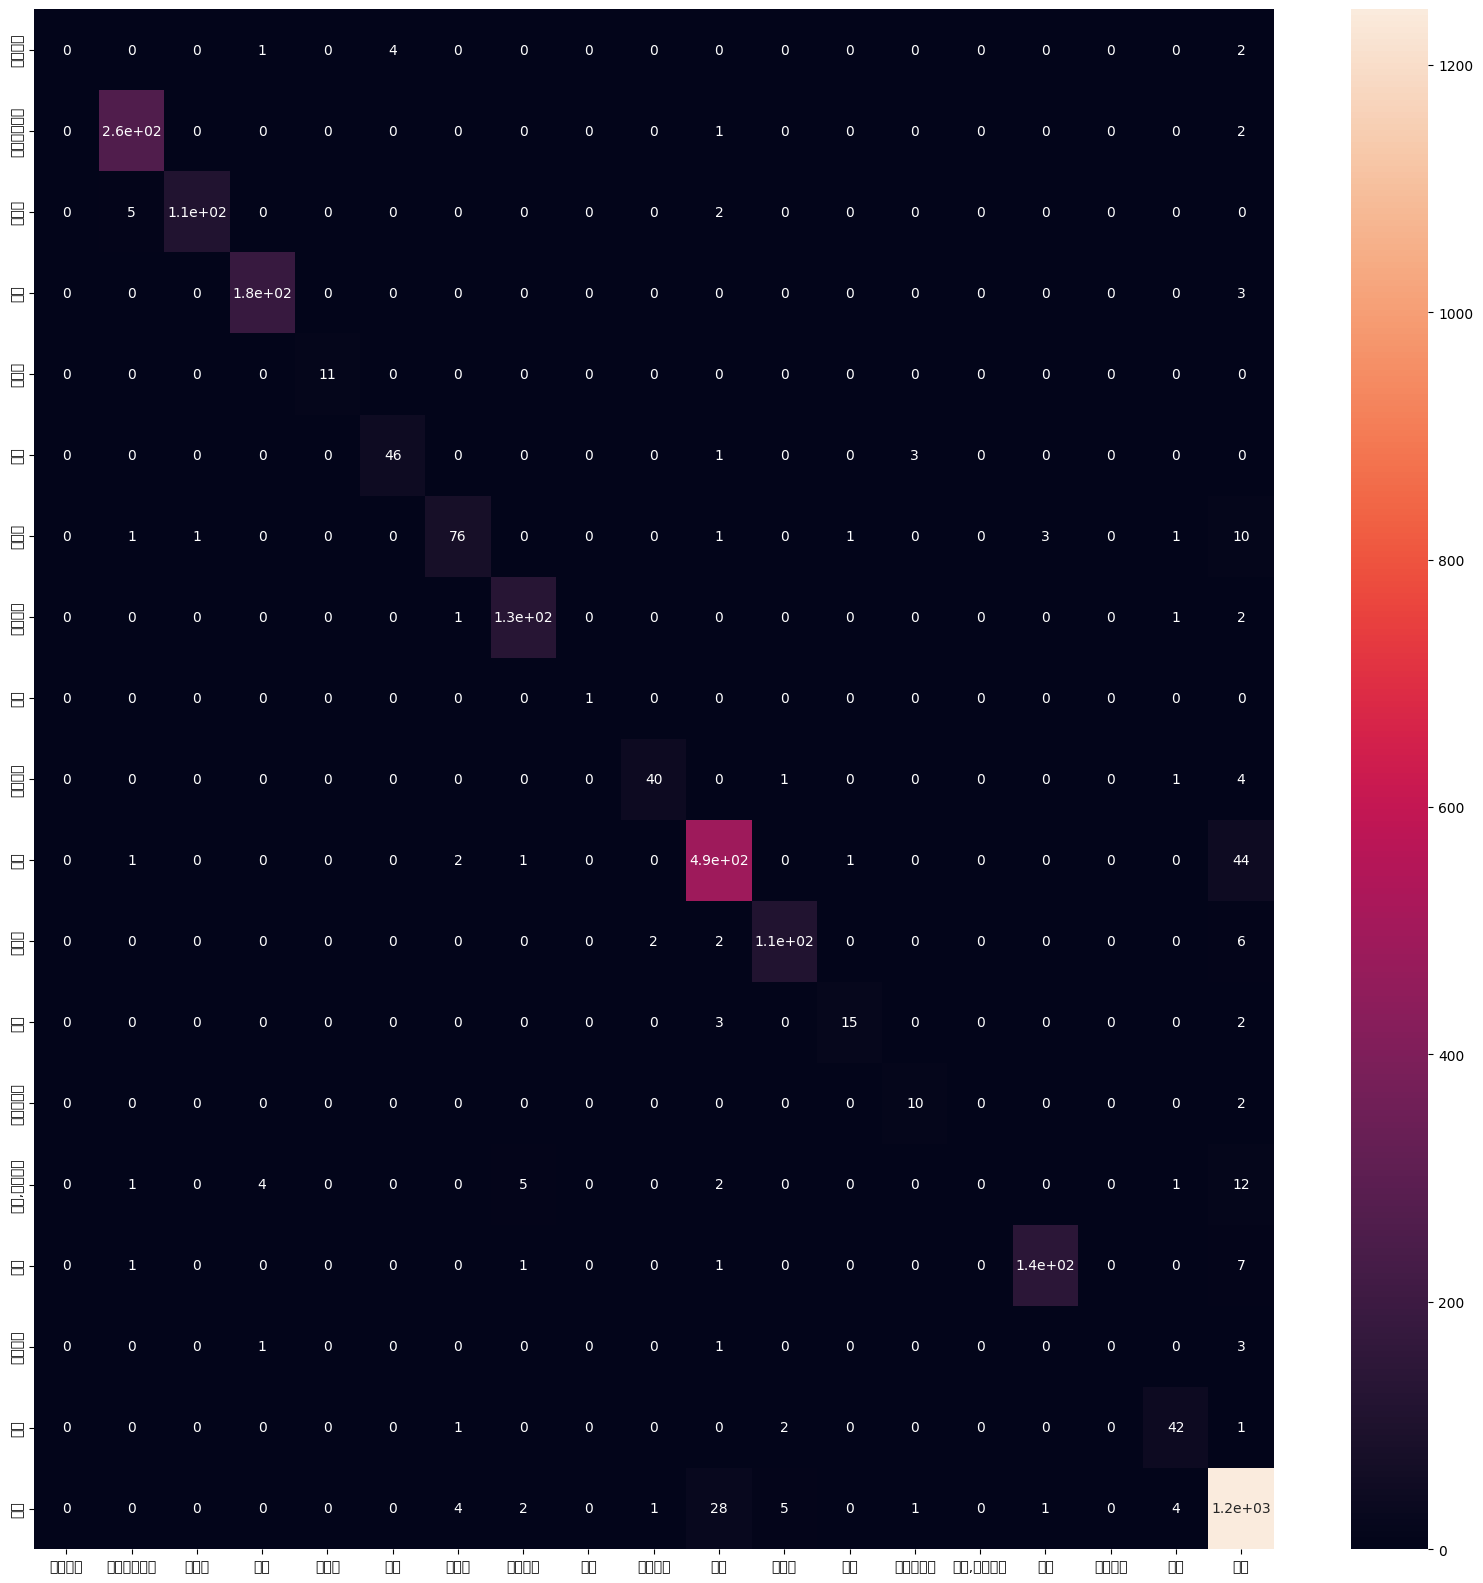

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (20,20))
sns.heatmap(con, annot = True)

### Inference

In [53]:
test = pd.read_csv('./test.csv')

test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle=False, num_workers=0)

In [54]:
def inference(model, test_dataloader):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_dataloader)):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    preds = le.inverse_transform(preds)
    return preds

In [55]:
import ttach as tta

tta_transforms = tta.Compose(
    [
        # tta.Resize([260,260]),
        # tta.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        tta.HorizontalFlip(),
        tta.Multiply(factors=[0.9, 1, 1.1]),
        # ToTensorV2()
                      
    ]
)

tta_model = tta.ClassificationTTAWrapper(model, tta_transforms)

In [56]:
preds2 = inference(tta_model, test_dataloader)

100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


In [53]:
preds = inference(model, test_dataloader)

100%|██████████| 25/25 [00:07<00:00,  3.37it/s]


In [58]:
was_training = model.training
model.train(mode=was_training);

### Submission

In [57]:
submit = pd.read_csv('./sample_submission.csv')

In [58]:
submit['label'] = preds2

In [59]:
submit.loc[submit['label'] == 'a', 'label'] = '가구수정'
submit.loc[submit['label'] == 'b', 'label'] = '걸레받이수정'
submit.loc[submit['label'] == 'c', 'label'] = '곰팡이'
submit.loc[submit['label'] == 'd', 'label'] = '꼬임'
submit.loc[submit['label'] == 'e', 'label'] = '녹오염'
submit.loc[submit['label'] == 'f', 'label'] = '들뜸'
submit.loc[submit['label'] == 'g', 'label'] = '면불량'
submit.loc[submit['label'] == 'h', 'label'] = '몰딩수정'
submit.loc[submit['label'] == 'i', 'label'] = '반점'
submit.loc[submit['label'] == 'j', 'label'] = '석고수정'
submit.loc[submit['label'] == 'k', 'label'] = '오염'
submit.loc[submit['label'] == 'l', 'label'] = '오타공'
submit.loc[submit['label'] == 'm', 'label'] = '울음'
submit.loc[submit['label'] == 'n', 'label'] = '이음부불량'
submit.loc[submit['label'] == 'o', 'label'] = '창틀,문틀수정'
submit.loc[submit['label'] == 'p', 'label'] = '터짐'
submit.loc[submit['label'] == 'q', 'label'] = '틈새과다'
submit.loc[submit['label'] == 'r', 'label'] = '피스'
submit.loc[submit['label'] == 's', 'label'] = '훼손'

In [60]:
submit['label'].value_counts()

label
훼손        342
오염        223
터짐         38
꼬임         38
오타공        30
면불량        27
몰딩수정       16
곰팡이        16
걸레받이수정     15
석고수정       12
피스          9
들뜸          8
이음부불량       7
녹오염         5
울음          4
반점          2
Name: count, dtype: int64

In [61]:
submit.to_csv('./tta1.csv', index=False)